Python 3.9.6

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

#1 Information sources

ice_cream -  U.S. Bureau of Labor Statistics | https://fred.stlouisfed.org/series/APU0000710411 |   
Average Price: Ice Cream, Prepackaged, Bulk, Regular, per One-Half Gallon (1.9 Liters) in U.S. City Average

milk - U.S. Bureau of Labor Statistics | https://fred.stlouisfed.org/series/WPU01610102 |   
 Producer Price Index by Commodity: Farm Products: Raw Milk

wages - U.S. Bureau of Labor Statistics | https://fred.stlouisfed.org/series/AHETPI |   
Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private

In [2]:
ice_cream = pd.read_csv('raw_data/ice_cream.csv', index_col=0)
milk = pd.read_csv('raw_data/milk.csv', index_col=0)
wages = pd.read_csv('raw_data/wages_production.csv', index_col=0)

df = pd.concat([ice_cream, milk, wages], axis = 1)

df.columns = ['ice_cream', 'milk', 'wages']     ### renaming column
df.index.name = 'date'                          ### rtenaming index
df.index = pd.to_datetime(df.index)             ### setting index data type as pd.datetime
df = df[df.index >= '1980-01-01']               ### only keeping the dates from 1980 (as data for ice cream starts from 1980-01-01)

### filling the missing value with the previous value (since the data is continious and not that volatile this should work as a good approximation)
df = df.fillna(method = 'ffill')  
df

/var/folders/t6/tk3jmq952n12z71x9qwyprsw0000gn/T/ipykernel_69992/1279577585.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


,ice_cream,milk,wages
date,,,
1980-01-01,1.755,93.200,6.57
1980-02-01,1.775,93.900,6.63
1980-03-01,1.718,93.500,6.69
1980-04-01,1.769,93.900,6.72
1980-05-01,1.822,93.900,6.76
...,...,...,...
2024-07-01,6.030,174.645,30.16
2024-08-01,6.357,180.773,30.26
2024-09-01,6.338,195.327,30.36


In [3]:
# df.to_csv('final_data.csv')     ### saving the data after all transformations

#2 Visualisation

In [4]:
y = df['ice_cream']         ### dependent variable
x = df[['milk', 'wages']]   ### regressors

scores = {}

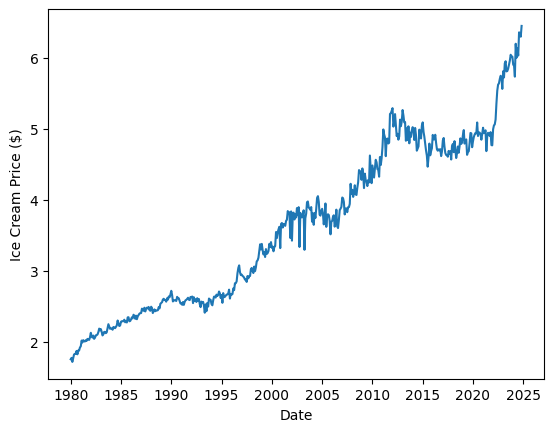

In [5]:
plt.plot(y)     ### simple line plot
plt.ylabel("Ice Cream Price ($)")
plt.xlabel("Date")
plt.show()

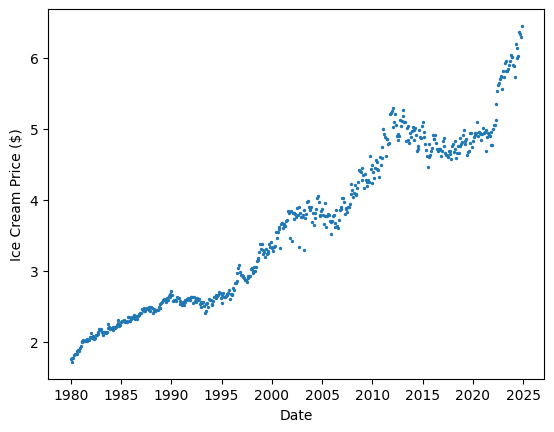

In [6]:
plt.scatter(y.index, y, s = 2)     ### simple scatter plot
plt.ylabel("Ice Cream Price ($)")
plt.xlabel("Date")
plt.show()

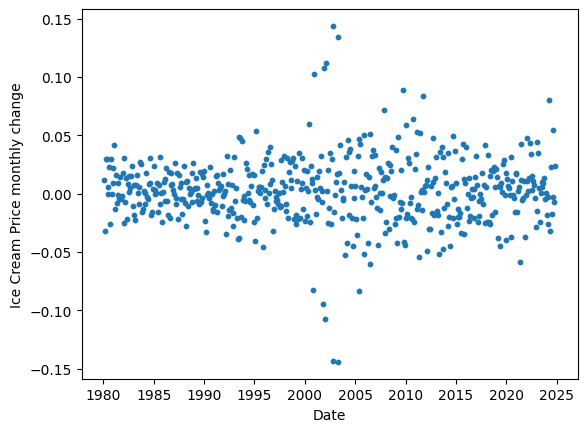

In [7]:
plt.scatter(y.index, y.pct_change(1), s = 10)      ### monthtly changes as scatter plot
plt.ylabel("Ice Cream Price monthly change")
plt.xlabel("Date")
plt.show()

In [8]:
### splitting into train and test samples (test = 1/3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle = False)
### shuffle is set to False since the data is TimeSeries and shuffling can lead to leakage 

#3 ETS decomposition

In [9]:
# fit ETS
ets_model = ETSModel(
    y_train,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods = 12,  ### = 12 since monthly data
)

ets_fit = ets_model.fit(disp = False)
print(ets_fit.summary())


                                 ETS Results                                  
Dep. Variable:              ice_cream   No. Observations:                  361
Model:                       ETS(AAA)   Log Likelihood                 370.303
Date:                Mon, 30 Dec 2024   AIC                           -704.606
Time:                        13:01:26   BIC                           -634.606
Sample:                    01-01-1980   HQIC                          -676.775
                         - 01-01-2010   Scale                            0.008
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3761      0.042      8.890      0.000       0.293       0.459
smoothing_trend      3.761e-05        nan        nan        nan         nan         nan
smoothing_season

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


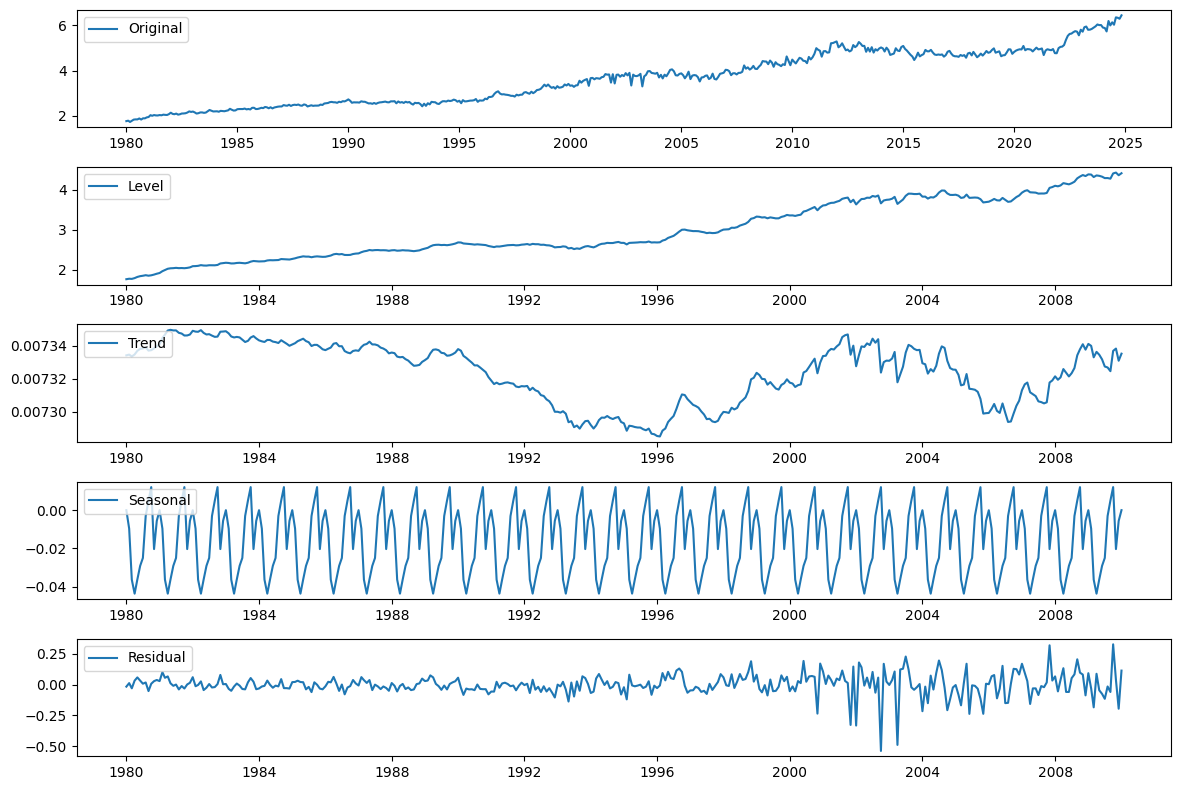

In [10]:
# Decompose components
pred_ETS_train = ets_fit.fittedvalues
level = ets_fit.level
trend = ets_fit.slope
seasonal = ets_fit.season
residual = ets_fit.resid

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.plot(y, label='Original')
plt.legend(loc='upper left')

plt.subplot(5, 1, 2)
plt.plot(level, label='Level')
plt.legend(loc='upper left')

plt.subplot(5, 1, 3)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(5, 1, 4)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(5, 1, 5)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


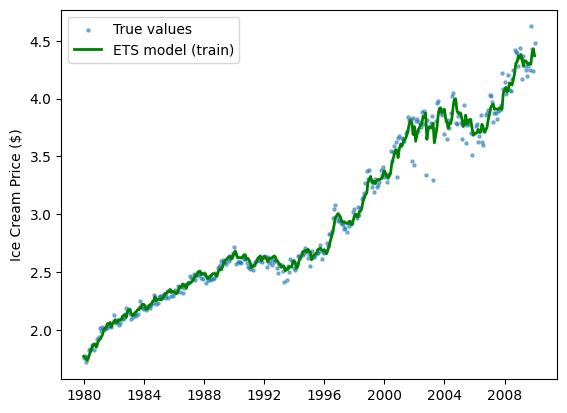

In [11]:
# Plot fitted values along with true values

plt.scatter(y_train.index, y_train, label="True values", s = 5, alpha = 0.5)
plt.plot(y_train.index, pred_ETS_train, label="ETS model (train)", color = 'green', linewidth = 2)
plt.ylabel("Ice Cream Price ($)")
plt.legend()
plt.show()

#4 Random Forest

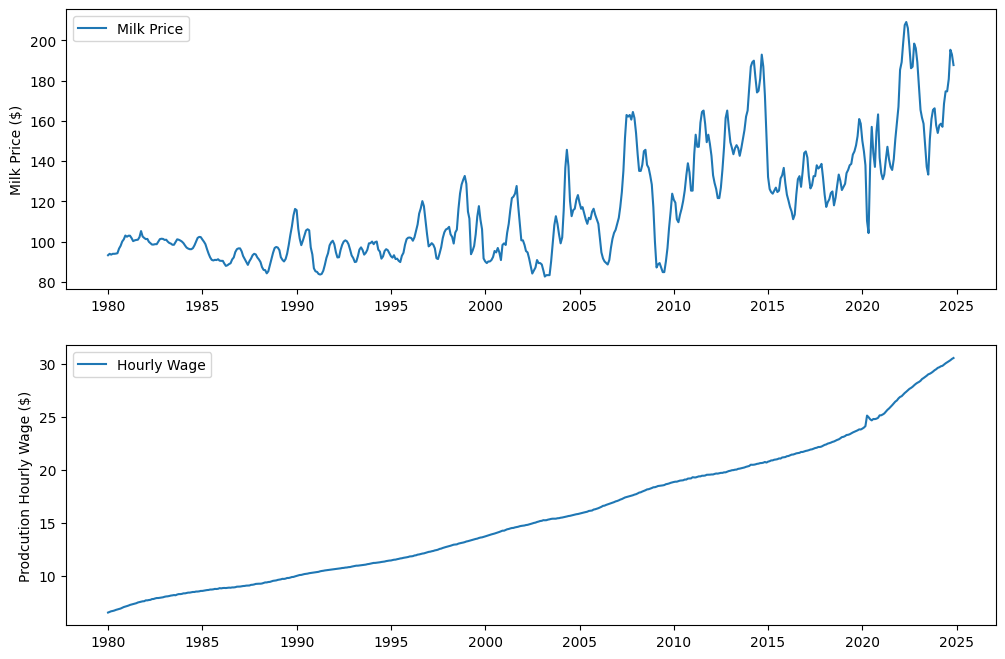

In [12]:
### plot of regressors

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x['milk'], label = 'Milk Price')
plt.ylabel('Milk Price ($)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x['wages'], label = 'Hourly Wage')
plt.ylabel('Prodcution Hourly Wage ($)')
plt.legend()

plt.show()

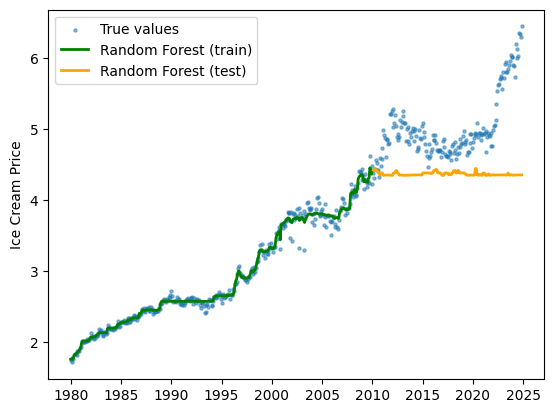

In [13]:
RF = RandomForestRegressor(max_depth=5, random_state = 1)
RF.fit(x_train, y_train)
pred_RF_train = RF.predict(x_train)
pred_RF_test = RF.predict(x_test)

plt.scatter(y.index, y, label="True values", s = 5, alpha = 0.5)
plt.plot(y_train.index, pred_RF_train, label="Random Forest (train)", color = 'green', linewidth = 2)
plt.plot(y_test.index, pred_RF_test, label="Random Forest (test)", color = 'orange', linewidth = 2)
plt.ylabel("Ice Cream Price")
plt.legend()
plt.show()

Since the time-series (both dependent and independent variables) are clearly not stationary, Random Forests's trees are not the optimal regresion algorithm, since they cannot adjust to trends due to their architechture. 

For this reason we will first detrend the time-series (both dependent and independent variables), for this purpose we will regress our 3 variables on a simple series of increasing numbers (0,1,2,3,4...) using Simple Linear OLS regression and then use the residuals of these regressions as new variables, thus performing a simple 2-step ensemble algorithm   


P.S. we are not using ETS for the trend decomposition just to show another approach

In [14]:
def trend_linear(train_sample, test_sample):

    ### arranging numbers
    numbers_train = np.array(range(len(train_sample))).reshape(-1, 1)
    numbers_test = np.array(range(len(train_sample), len(train_sample) + len(test_sample))).reshape(-1, 1)

    ### setting up a Linear Regression
    regr = LinearRegression()
    regr.fit(numbers_train, train_sample)

    ### Getting predictions

    pred_regr_train = regr.predict(numbers_train)
    pred_regr_test = regr.predict(numbers_test)

    return pred_regr_train, pred_regr_test

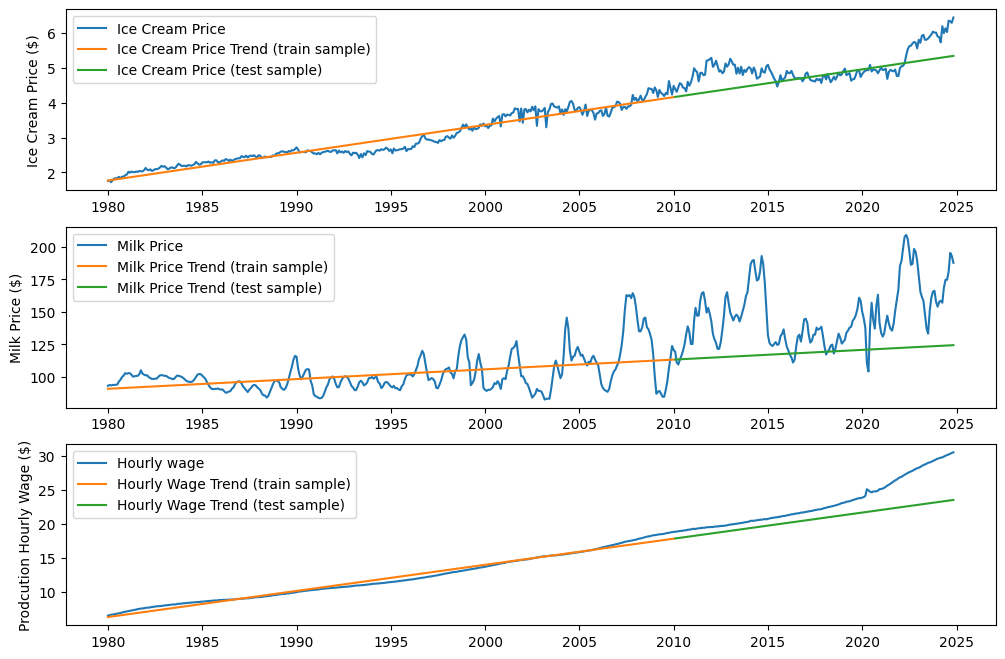

In [15]:
ice_cream_trend_train, ice_cream_trend_test = trend_linear(y_train, y_test)
milk_trend_train, milk_trend_test = trend_linear(x_train['milk'], x_test['milk'])
wages_trend_train, wages_trend_test = trend_linear(x_train['wages'], x_test['wages'])

### plot of trended data

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(y, label = 'Ice Cream Price')
plt.plot(y_train.index, ice_cream_trend_train, label = 'Ice Cream Price Trend (train sample)')
plt.plot(y_test.index, ice_cream_trend_test, label = 'Ice Cream Price (test sample)')
plt.ylabel('Ice Cream Price ($)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(x['milk'], label = 'Milk Price')
plt.plot(x_train.index, milk_trend_train, label = 'Milk Price Trend (train sample)')
plt.plot(x_test.index, milk_trend_test, label = 'Milk Price Trend (test sample)')
plt.ylabel('Milk Price ($)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x['wages'], label = 'Hourly wage')
plt.plot(x_train.index, wages_trend_train, label = 'Hourly Wage Trend (train sample)')
plt.plot(x_test.index, wages_trend_test, label = 'Hourly Wage Trend (test sample)')
plt.ylabel('Prodcution Hourly Wage ($)')
plt.legend()

plt.show()

In [16]:
y_train_residual = y_train - ice_cream_trend_train
y_test_residual = y_test - ice_cream_trend_test

milk_train_residual = x_train['milk'] - milk_trend_train
milk_test_residual = x_test['milk'] - milk_trend_test

wages_train_residual = x_train['wages'] - wages_trend_train
wages_test_residual = x_test['wages'] - wages_trend_test

x_train_residual = pd.concat([milk_train_residual, wages_train_residual], axis = 1)
x_test_residual = pd.concat([milk_test_residual, wages_test_residual], axis = 1)

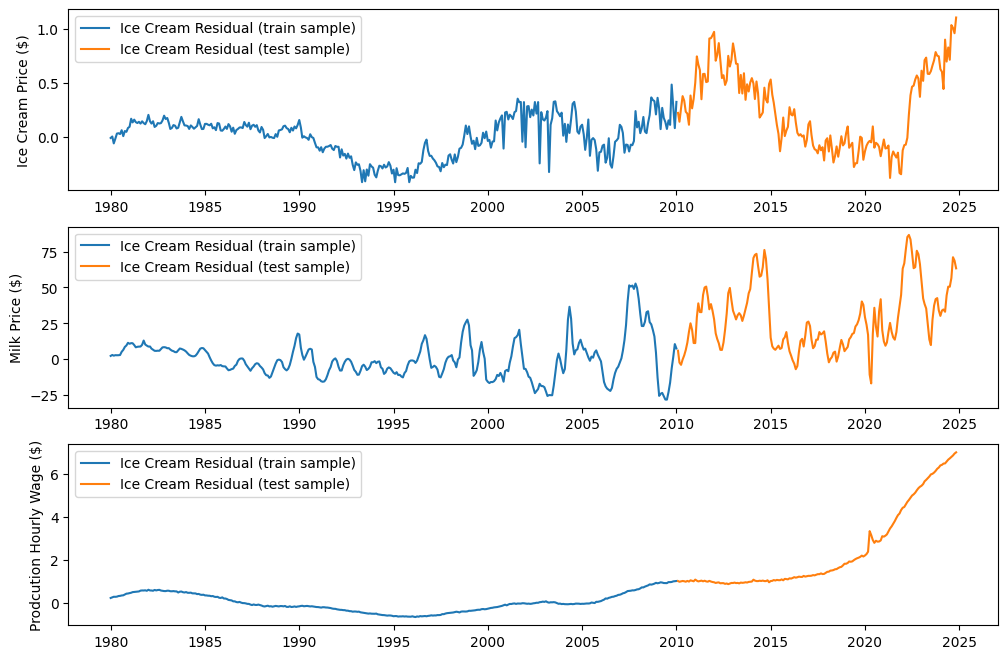

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(y_train_residual, label = 'Ice Cream Residual (train sample)')
plt.plot(y_test_residual, label = 'Ice Cream Residual (test sample)')
plt.ylabel('Ice Cream Price ($)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(milk_train_residual, label = 'Ice Cream Residual (train sample)')
plt.plot(milk_test_residual, label = 'Ice Cream Residual (test sample)')
plt.ylabel('Milk Price ($)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(wages_train_residual, label = 'Ice Cream Residual (train sample)')
plt.plot(wages_test_residual, label = 'Ice Cream Residual (test sample)')
plt.ylabel('Prodcution Hourly Wage ($)')
plt.legend()

plt.show()

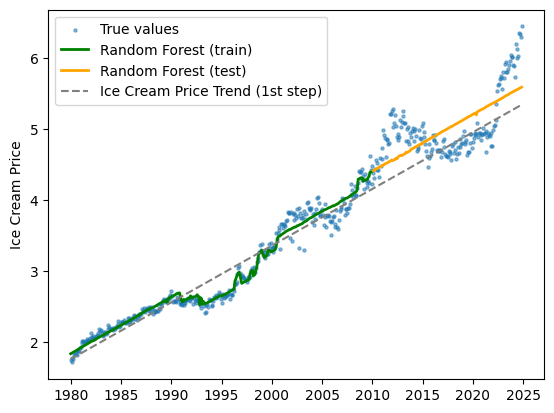

In [18]:
RF_2 = RandomForestRegressor(max_depth=3, random_state = 1)
RF_2.fit(x_train_residual, y_train_residual)
pred_RF_train_2 = RF_2.predict(x_train_residual)
pred_RF_test_2 = RF_2.predict(x_test_residual)

R2_RF = r2_score(y_test, pred_RF_test_2 + ice_cream_trend_test)
MSE_RF = mean_squared_error(y_test, pred_RF_test_2 + ice_cream_trend_test)
MAPE_RF = mean_absolute_percentage_error(y_test, pred_RF_test_2 + ice_cream_trend_test)

scores['Random Forest'] = [R2_RF, MSE_RF, MAPE_RF]

plt.scatter(y.index, y, label="True values", s = 5, alpha = 0.5)
plt.plot(y_train.index, pred_RF_train_2 + ice_cream_trend_train, label="Random Forest (train)", color = 'green', linewidth = 2)
plt.plot(y_test.index, pred_RF_test_2 + ice_cream_trend_test, label="Random Forest (test)", color = 'orange', linewidth = 2)
plt.plot(y.index, np.append(ice_cream_trend_train,ice_cream_trend_test), label = 'Ice Cream Price Trend (1st step)', linestyle="--", color="grey")
plt.ylabel("Ice Cream Price")
plt.legend()
plt.show()

The detrending procedure turned out to be effective, allowing a Random Forest model to work with non-stationary data, and resulting in a good prediciton for the test sample

#5 Prediction by ETS

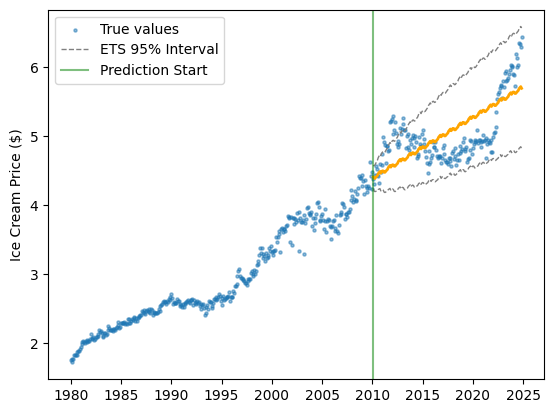

In [19]:
pred_ETS_test = ets_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1]).summary_frame(alpha=0.05)

R2_ETS = r2_score(y_test, pred_ETS_test['mean'])
MSE_ETS = mean_squared_error(y_test, pred_ETS_test['mean'])
MAPE_ETS = mean_absolute_percentage_error(y_test, pred_ETS_test['mean'])

scores['ETS'] = [R2_ETS, MSE_ETS, MAPE_ETS]

plt.scatter(y.index, y, label="True values", s = 5, alpha = 0.5)

plt.plot(y_test.index, pred_ETS_test['mean'], color = 'orange', linewidth = 2)
plt.plot(y_test.index, pred_ETS_test['pi_lower'], linestyle="--", color="grey", label="ETS 95% Interval", linewidth = 1)
plt.plot(y_test.index, pred_ETS_test['pi_upper'], linestyle="--", color="grey", label="_", linewidth = 1)

plt.axvline(x = y_test.index[0], color = 'green', label = 'Prediction Start', alpha = 0.5)

plt.legend()
plt.ylabel("Ice Cream Price ($)")
plt.show()

The ETS prediction was also good, clearly showing correct trend and seasonality for the data, while 95% confidence interval correctly captured most of the movement of the dependent variable

#6

Here we will use a simple Milti-layer Perceptron fitted to detrended data we used for Random Forest

The number of layers is chosen empirically, without performing a cross-validation (since it would be very computationally intense). Additionally we perform N iterations (10 proves to be sufficient) of fitting and predicting and then take the average of the predicitons, which effectively lowers the variance of the predictions which turns out to be very high for any individual fitting due to the random nature of the MLP layer-weights initialisation


Fitting MLPs...: 100%|██████████| 10/10 [02:31<00:00, 15.18s/it]


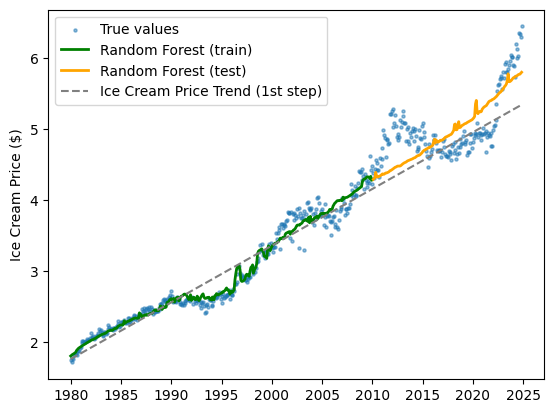

In [20]:
pred_MLP_train = np.zeros(shape = len(y_train_residual))
pred_MLP_test = np.zeros(shape = len(y_test_residual))

iters_ = 10

for i in tqdm(range(iters_), "Fitting MLPs..."):
    MLP = MLPRegressor(hidden_layer_sizes = (1000, 1000, 1000, 1000, 100), shuffle = False, max_iter=1000, random_state = i)
    MLP.fit(x_train_residual, y_train_residual)

    pred_MLP_train_i = MLP.predict(x_train_residual)
    pred_MLP_test_i = MLP.predict(x_test_residual)

    pred_MLP_train += pred_MLP_train_i
    pred_MLP_test += pred_MLP_test_i

pred_MLP_train = pred_MLP_train / iters_
pred_MLP_test = pred_MLP_test / iters_

R2_MLP = r2_score(y_test, pred_MLP_test + ice_cream_trend_test)
MSE_MLP = mean_squared_error(y_test, pred_MLP_test + ice_cream_trend_test)
MAPE_MLP = mean_absolute_percentage_error(y_test, pred_MLP_test + ice_cream_trend_test)

scores['MLP'] = [R2_MLP, MSE_MLP, MAPE_MLP]

plt.scatter(y.index, y, label="True values", s = 5, alpha = 0.5)
plt.plot(y_train.index, pred_MLP_train + ice_cream_trend_train, label="Random Forest (train)", color = 'green', linewidth = 2)
plt.plot(y_test.index, pred_MLP_test + ice_cream_trend_test, label="Random Forest (test)", color = 'orange', linewidth = 2)
plt.plot(y.index, np.append(ice_cream_trend_train,ice_cream_trend_test), label = 'Ice Cream Price Trend (1st step)', linestyle="--", color="grey")
plt.ylabel("Ice Cream Price ($)")
plt.legend()
plt.show()

MLP shows similar results to ETS and RF, but requires significantly more computation and produces very high variance of predictions if not averaged (which in turn requires even more computation)

#7 Results

In [21]:
pd.DataFrame(scores, index = ['R2', 'MSE','MAPE'])

,Random Forest,ETS,MLP
R2,0.375637,0.353260,0.374206
MSE,0.128669,0.133280,0.128964
MAPE,0.061902,0.063984,0.061087


According to R2, MSE and MAPE all 3 models perform good on the test sample. However, Random Forest and MLP show slightly better results than ETS. The reason for that might be that ETS does not consider some valuable information from the independent variables. At the same time Random Forest and MLP are very similar in results, though RF has a higher R2 and MLP has a smaller MAPE.   

However, considering that Random Forest generally has lower variance of predictions (which we empirically tested) even compared to averaged MLP, we would suggest using this model in the real application. Additionaly, Random Forest is also significantly less computationally intense

#8

In [22]:
"""


.::::::::..          ..::::::::.
 :::::::::::::        :::::::::::::
:::::::::::' .\      /. `:::::::::::
`::::::::::_,__o    o__,_::::::::::'


"""

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/t6/tk3jmq952n12z71x9qwyprsw0000gn/T/ipykernel_69992/2727511550.py:1: SyntaxWarning: invalid escape sequence '\ '
  """


"\n\n\n.::::::::..          ..::::::::.\n :::::::::::::        :::::::::::::\n:::::::::::' .\\      /. `:::::::::::\n`::::::::::_,__o    o__,_::::::::::'\n\n\n"